In [8]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import pdal

import xarray as xr

from forest_structure_tools.cloud_metrics import height_metrics, percentile_metrics, relative_height_profile_metrics, percent_above, percent_below, percent_in, percent_at

In [9]:
data_dir = Path("../data")
plots_lidar_dir = data_dir / "outputs" / "plots" / "lidar"

In [10]:
def read_plot(plot_id: str):
    file_path = plots_lidar_dir / f"{plot_id}.copc.laz"
    pl = pdal.Reader(str(file_path)).pipeline()
    pl.execute()
    return pl.arrays[0]


In [11]:
points = read_plot("AGG_O_01_P1")

In [12]:

points_xr = xr.Dataset(
    data_vars={
        "x": ("point", points["X"]),
        "y": ("point", points["Y"]),
        "z": ("point", points["Z"]),
        "rn": ("point", points["ReturnNumber"]),
        "weights": ("point", 1 / points["NumberOfReturns"])
    },
    coords={
        "point": np.arange(len(points))
    }
)

points_xr.head()

<xarray.Dataset> Size: 205B
Dimensions:  (point: 5)
Coordinates:
  * point    (point) int64 40B 0 1 2 3 4
Data variables:
    x        (point) float64 40B 4.63e+05 4.63e+05 4.63e+05 4.63e+05 4.63e+05
    y        (point) float64 40B 5.26e+06 5.26e+06 5.26e+06 5.26e+06 5.26e+06
    z        (point) float64 40B 0.0 0.0 0.0 3.202 0.0
    rn       (point) uint8 5B 2 2 2 1 2
    weights  (point) float64 40B 0.5 0.5 0.5 0.5 0.5

In [13]:
res = 100

x_bins = np.arange(points_xr['x'].min(), points_xr['x'].max() + res, res)
y_bins = np.arange(points_xr['y'].min(), points_xr['y'].max() + res, res)

raster_group = points_xr.groupby(
    x=xr.groupers.BinGrouper(bins=x_bins),
    y=xr.groupers.BinGrouper(bins=y_bins)
)

In [14]:
def foo(ds):

    z = ds.z.values
    weights = ds.weights.values

    total = len(z)

    height_bins = np.arange(0, z.max(), 1)
    height_counts, _ = np.histogram(z, bins=height_bins)
    height_labels = (height_bins[:-1] + height_bins[1:]) / 2

    return xr.Dataset(
        data_vars= {
            **height_metrics(z),
            **percent_above(z, threshold=1.5),
            **percent_above(z, threshold=1.5, weights=weights, suffix='w'),
            **percent_at(z, 0),
            **percent_in(z, threshold=(0, 1)),
        },
        coords= {
            "heights": height_labels
        }
    )

raster = raster_group.map(foo)
raster.head()

<xarray.Dataset> Size: 152B
Dimensions:      (x_bins: 1, y_bins: 1, heights: 5)
Coordinates:
  * x_bins       (x_bins) object 8B (462975.769, 463075.769]
  * y_bins       (y_bins) object 8B (5259799.916, 5259899.916]
  * heights      (heights) float64 40B 0.5 1.5 2.5 3.5 4.5
Data variables:
    max_h        (x_bins, y_bins) float64 8B 16.28
    min_h        (x_bins, y_bins) float64 8B 0.0
    range_h      (x_bins, y_bins) float64 8B 16.28
    mean_h       (x_bins, y_bins) float64 8B 4.428
    median_h     (x_bins, y_bins) float64 8B 4.555
    sd_h         (x_bins, y_bins) float64 8B 4.093
    var_h        (x_bins, y_bins) float64 8B 16.76
    cv_h         (x_bins, y_bins) float64 8B 0.9244
    %gt_1.5m     (x_bins, y_bins) float64 8B 59.09
    %gt_1.5m[w]  (x_bins, y_bins) float64 8B 56.41
    %at_0m       (x_bins, y_bins) float64 8B 21.58
    %in_(0,1m]   (x_bins, y_bins) float64 8B 18.03

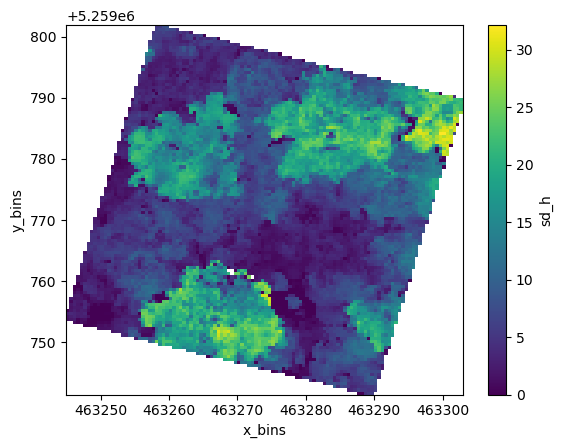

In [ ]:
raster["sd_h"].T.plot()

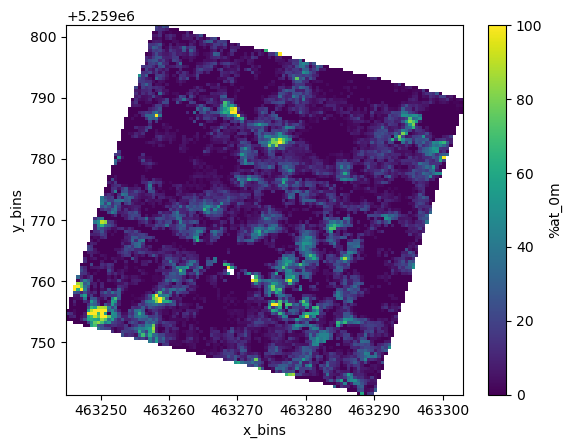

In [ ]:
raster["%at_0m"].T.plot()

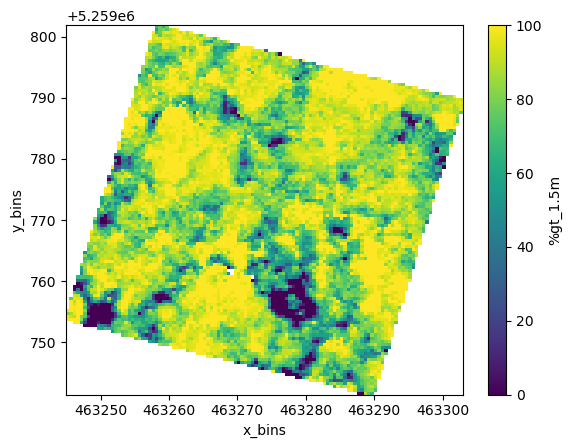

In [ ]:
raster["%gt_1.5m"].T.plot()

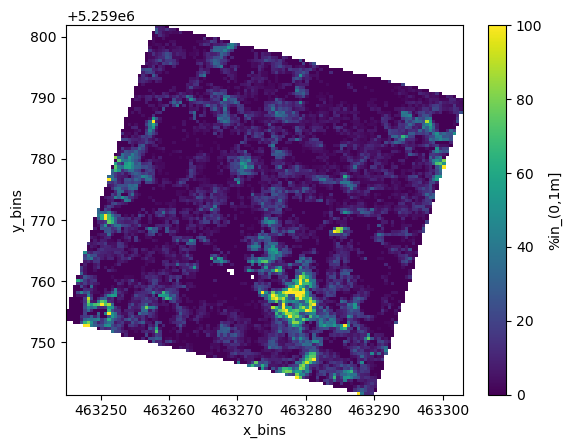

In [ ]:
raster["%in_(0,1m]"].T.plot()

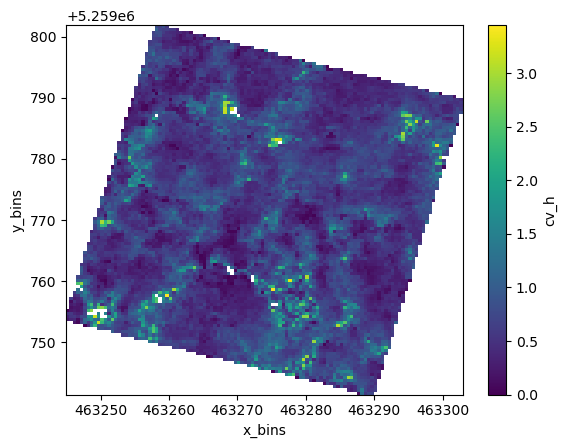

In [ ]:
raster["cv_h"].T.plot()